In [12]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

In [2]:
cleaned_data = pd.read_csv("/content/cleaned_df.csv")

In [3]:
cleaned_data = cleaned_data.drop(columns = "Unnamed: 0")

In [4]:
numeric_data = cleaned_data.drop(columns = ["Company Ticker", 
                                                 "Sector", 
                                                 "Class",
                                                 "PRICE VAR [%]"
                                                 ])

In [5]:
Y_1 = cleaned_data['Class']
Y_2 = cleaned_data["PRICE VAR [%]"]

In [6]:
cat_1 = cleaned_data['Company Ticker']
cat_2 = cleaned_data['Sector']

In [7]:
pd.get_dummies(cat_1, prefix='Company')

,Company_A,Company_AA,Company_AABA,Company_AAL,Company_AAMC,Company_AAME,Company_AAN,Company_AAOI,Company_AAON,Company_AAPL,Company_AAT,Company_AAU,Company_AAWW,Company_AAXN,Company_AB,Company_ABB,Company_ABBV,Company_ABC,Company_ABCB,Company_ABEO,Company_ABEV,Company_ABG,Company_ABIL,Company_ABIO,Company_ABM,Company_ABMD,Company_ABR,Company_ABT,Company_ABTX,Company_ABUS,Company_AC,Company_ACAD,Company_ACBI,Company_ACC,Company_ACCO,Company_ACER,Company_ACGL,Company_ACH,Company_ACHC,Company_ACHN,...,Company_XRX,Company_XSPA,Company_XTLB,Company_XTNT,Company_XXII,Company_XYL,Company_Y,Company_YELP,Company_YGYI,Company_YIN,Company_YNDX,Company_YORW,Company_YPF,Company_YRCW,Company_YRD,Company_YRIV,Company_YTEN,Company_YUM,Company_YUMA,Company_YY,Company_Z,Company_ZAGG,Company_ZAYO,Company_ZBH,Company_ZBRA,Company_ZEN,Company_ZEUS,Company_ZFGN,Company_ZG,Company_ZGNX,Company_ZION,Company_ZIOP,Company_ZIXI,Company_ZN,Company_ZNGA,Company_ZNH,Company_ZSAN,Company_ZTS,Company_ZUMZ,Company_ZYNE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18627,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## too sparse, drop company ticker

In [8]:
cat_data = pd.get_dummies(cat_2, prefix='sector')

## Numeric Data

In [9]:
check_corr = pd.concat([numeric_data,Y_1],axis = 1)

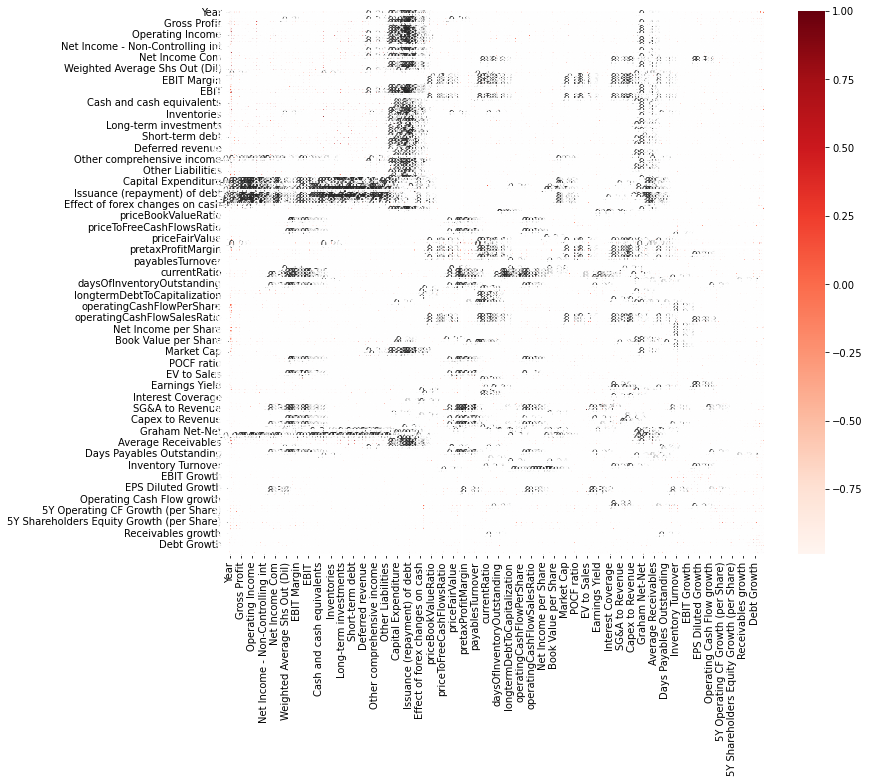

In [10]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = check_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## set correlation threshold to 0.05 and 86 features left

In [15]:
#Correlation with output variable
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
len(relevant_features)

87

In [16]:
rele_columns = relevant_features.index[:-1]

In [17]:
rele_columns

Index(['Operating Income', 'Earnings before Tax', 'Net Income',
       'Net Income Com', 'EPS', 'EPS Diluted', 'Dividend per Share',
       'Gross Margin', 'EBITDA Margin', 'EBIT Margin', 'Profit Margin',
       'Free Cash Flow margin', 'EBIT', 'Consolidated Income',
       'Earnings Before Tax Margin', 'Net Profit Margin',
       'Total current assets', 'Deferred revenue',
       'Retained earnings (deficit)', 'Stock-based compensation',
       'Issuance (buybacks) of shares', 'Effect of forex changes on cash',
       'Free Cash Flow', 'priceToSalesRatio', 'priceEarningsRatio',
       'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio',
       'priceSalesRatio', 'ebitperRevenue', 'grossProfitMargin',
       'pretaxProfitMargin', 'netProfitMargin', 'returnOnEquity',
       'eBITperRevenue', 'currentRatio', 'quickRatio', 'cashRatio',
       'daysOfPayablesOutstanding', 'longtermDebtToCapitalization',
       'interestCoverage', 'companyEquityMultiplier', 'freeCashFlowPerShare',

In [18]:
corr_2 = numeric_data[rele_columns]

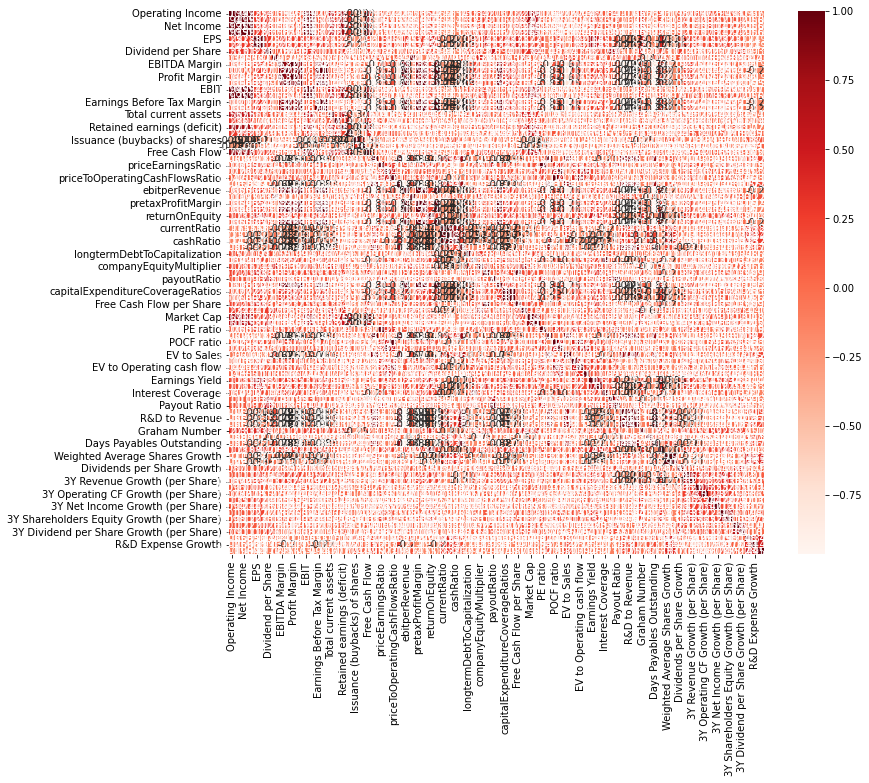

In [19]:
plt.figure(figsize=(12,10))
cor = corr_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [20]:
selected_features = numeric_data[rele_columns]

In [21]:
final_features = pd.concat([selected_features,cat_data],axis = 1)

In [22]:
df = pd.concat([final_features,Y_1],axis = 1)

In [33]:
df.shape

(18630, 98)

In [23]:
df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

target = df['Class']
price_columns = ['Class']
data = df.loc[:, ~df.columns.isin(price_columns)]

# the following variable records the features of examples in the training set
train_x = data.iloc[:t]
# the following variable records the features of examples in the test set
test_x = data.iloc[t:]
# the following variable records the labels of examples in the training set
train_y = target[:t]
# the following variable records the labels of examples in the test set
test_y = target[t:]

Size of dataset:  18630


In [24]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)
train_y_np = np.asarray(train_y)
test_y_np = np.asarray(test_y)

In [34]:
train_x_np.shape

(14904, 97)

## normalization

In [28]:
def normalize(x,s=None,m=None):
  if s is None or m is None:
    s = np.std(x,axis=0)
    m = np.mean(x,axis=0)
  x = (x-m)/s
  return x,s,m

In [29]:
x,s,m = normalize(train_x_np[:,:-11])
x_test,_,_ = normalize(test_x_np[:,:-11],s,m)

In [35]:
train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)

In [36]:
clf = LogisticRegression(random_state=0).fit(train_x_np, train_y_np)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [37]:
clf.score(test_x_np, test_y_np)

0.6078904991948471

In [38]:
y_pred = clf.predict(test_x_np)

In [39]:
f1_score(test_y_np, y_pred, average='weighted')

0.5927945719373362

In [55]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,),learning_rate= early_stopping = True)

In [56]:
clf.fit(train_x_np, train_y_np)

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(10,))

In [57]:
clf.score(test_x_np, test_y_np)

0.6154052603327965

In [58]:
y_pred = clf.predict(test_x_np)

In [59]:
f1_score(test_y_np, y_pred, average='weighted')

0.6071098187258861

In [62]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.6 MB/s 


In [63]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [95]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [96]:
search_space = {
    "learning_rate_init": (1e-5,1.0),
    "alpha": (1e-5,1.0)
}


In [97]:
clf_bayes = BayesSearchCV(MLPClassifier(hidden_layer_sizes=(100,)), search_space)

In [ ]:
clf_bayes.fit(train_x_np, train_y_np)

In [100]:
clf_bayes.score(test_x_np, test_y_np)

0.6180891035963499